In [1]:
import numpy as np
import pandas as pd

In [2]:
import operator

from copy import copy

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
df_train = pd.read_csv("../data/train.txt", sep='\t', header=None, names=["users", "items", "rank"])
df_train.head()

,users,items,rank
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [6]:
df_train["rank"].unique()

array([5, 3, 4, 1, 2])

In [7]:
n_users = df_train["users"].max()
n_items = df_train["items"].max()

In [8]:
df_train[["users", "items"]] -= 1
df_train.head()

,users,items,rank
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,3
4,0,4,3


In [9]:
def iter_step(weights, bias, C, alpha):
    weights_, bias_ = copy(weights), copy(bias)
    
    global n_users
    global n_items
    global matrix
    
    for user in range(n_users):
        Q = weights_["items"]
        Q = np.hstack((np.ones(shape=(n_items, 1), dtype=float), Q))
        r = r_matrix[user, :].reshape(-1) - bias_["items"]
        G = np.diag(G_matrix[user, :]) # np.diag(1.0 + alpha * r)
        
        A = np.dot(Q.T, np.dot(G, Q)) + C * np.eye(Q.shape[1])
        b = np.dot(Q.T, np.dot(G, r))
        
        solution = np.linalg.solve(A, b)
        weights_["users"][user], bias_["users"][user] = solution[1:], solution[0]
        
    for item in range(n_items):
        P = weights_["users"]
        P = np.hstack((np.ones(shape=(n_users, 1), dtype=float), P))
        r = r_matrix[:, item].reshape(-1) - bias_["users"]
        G = np.diag(G_matrix[:, item]) # np.diag(1.0 + alpha * r)
        
        A = np.dot(P.T, np.dot(G, P)) + C * np.eye(P.shape[1])
        b = np.dot(P.T, np.dot(G, r))
        
        solution = np.linalg.solve(A, b)
        weights_["items"][item], bias_["items"][item] = solution[1:], solution[0]
        
    return weights_, bias_

In [10]:
df_grouped = {cat : df_train.groupby(by=cat) for cat in ["users", "items"]}

In [11]:
df_test = pd.read_csv("../data/test.txt", sep='\t', header=None, names=["users", "items"])
df_test.head()

,users,items
0,1,20
1,1,33
2,1,61
3,1,117
4,1,155


In [12]:
df_test[["users", "items"]] -= 1
df_test.head()

,users,items
0,0,19
1,0,32
2,0,60
3,0,116
4,0,154


In [13]:
def score(matrix, values):
    y_pred = [matrix[user, item] for user, item, rank in values]
    y_true = map(operator.itemgetter(2), values)
    return mean_squared_error(y_true, y_pred)

In [14]:
def score_predict(matrix, values, i):
    pred = np.clip([matrix[user, item] for user, item in values], a_min=1, a_max=5)
    submission = pd.DataFrame(list(enumerate(pred)), columns=["Id", "Mark"])
    submission["Id"] += 1
    submission.to_csv("./submissions/submission_{:02}.csv".format(i), index=False)

In [15]:
r_matrix = np.zeros(shape=(n_users, n_items), dtype=float)
for user, item, rank in df_train.values:
    r_matrix[user, item] = rank
    
G_matrix = (r_matrix > 0).astype(float)
G_matrix += (G_matrix == 0).astype(float) * 0.01

for user, group in df_grouped["users"]:
    mask = r_matrix[user, :] == 0
    r_matrix[user, mask] = group["rank"].mean()

In [16]:
C = 5.0
n_features = 2
alpha = 0.13

In [17]:
weights = dict()
weights["users"] = np.random.normal(loc=0.0, scale=0.01, size=(n_users, n_features))
weights["items"] = np.random.normal(loc=0.0, scale=0.01, size=(n_items, n_features))

bias = dict()
bias["users"] = np.random.normal(loc=0.0, scale=0.01, size=(n_users, ))
bias["items"] = np.random.normal(loc=0.0, scale=0.01, size=(n_items, ))

In [18]:
scores = []

In [ ]:
n_iters = 210

for i in range(n_iters):
    weigths, bias = iter_step(weights, bias, C, alpha)
    matrix = bias["users"].reshape(-1, 1) + bias["items"].reshape(1, -1) \
            + np.dot(weights["users"], weights["items"].T)
    scores.append(score(matrix, df_train.values))
    score_predict(matrix, df_test.values, i + 1)
    print "\r{} of {} iters passed...".format(i + 1, n_iters),

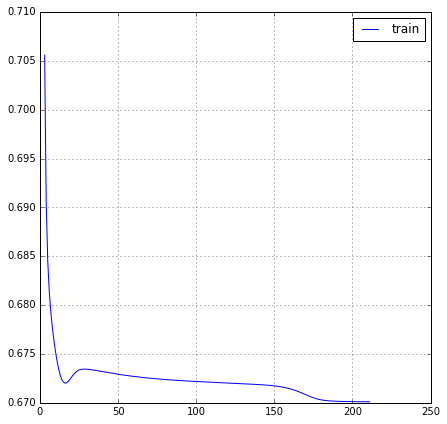

In [26]:
offset = 2

plt.figure(figsize=(7, 7))
plt.plot(range(offset+1, len(scores)+1), scores[offset:], label="train")
plt.legend()
plt.grid()

In [27]:
np.argsort(scores)

array([210, 209, 208, 207, 206, 205, 204, 203, 202, 201, 200, 199, 198,
       197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185,
       184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172,
       171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159,
       158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146,
       145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133,
       132, 131, 130, 129, 128, 127, 126, 125, 124, 123,  15, 122, 121,
       120, 119, 118, 117,  16, 116, 115, 114, 113, 112, 111, 110, 109,
        14, 108, 107, 106, 105, 104, 103, 102, 101, 100,  17,  99,  98,
        97,  96,  95,  94,  93,  92,  91,  90,  89,  88,  87,  86,  85,
        84,  83,  82,  81,  18,  13,  80,  79,  78,  77,  76,  75,  74,
        73,  72,  71,  70,  69,  68,  67,  66,  19,  65,  64,  63,  62,
        61,  60,  59,  58,  57,  56,  55,  20,  54,  12,  53,  52,  51,
        50,  49,  48,  47,  21,  46,  45,  44,  43,  42,  41,  2